In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
#import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0           conda-forge
    geopy:          

## Word processing function as part of raw data clean up to facilitate the usage of geopy 

In [2]:
def wordcut(x):
    stopwords = ['first','second','third','fourth','fifth']
    mydict = {'first':'1' ,'second':'2','third':'3','fourth':'4','fifth':'5'}
    qwords = x.split()
    resultwords = ""
    for words in qwords:
        if words.lower() in stopwords:
            resultwords = resultwords + ' ' + mydict[words.lower()]
        else:
            resultwords = resultwords + ' ' + words
    return resultwords

## Function to return the venues in dataframe

In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

## Function that returns the top X venues as specified by the passed parameters

In [22]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

## Initialization of the foursquares API parameters

In [24]:
CLIENT_ID = 'NS54JN201NE3OXSGOI40UKCSVHZWN45VJNAAEAVB4PIQU2BG' # your Foursquare ID
CLIENT_SECRET = 'ZONWPENSV3CHKTZQH1D5JJ1ZMR3ZKNQJQA0PAG3XFSSFHW1I' # your Foursquare Secret
VERSION = '20180604'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: NS54JN201NE3OXSGOI40UKCSVHZWN45VJNAAEAVB4PIQU2BG
CLIENT_SECRET:ZONWPENSV3CHKTZQH1D5JJ1ZMR3ZKNQJQA0PAG3XFSSFHW1I


## Read Dubai community data from wikipedia into a data frame using read_html followed by preliminary data processing

In [5]:
url = 'https://en.wikipedia.org/wiki/List_of_communities_in_Dubai'
DF = pd.read_html(url)
DubaiDF = DF[0]
DubaiDF.drop(['Community (Arabic)','Community Number'],axis = 1,inplace = True)
DubaiDF.rename(columns={"Community (English)" : "Community","Area(km2)": "Area", "Population(2000)":"Population","Population density(/km2)":"Density"}, inplace = True)
DubaiDF.dropna(inplace=True)
DubaiDF.reset_index(inplace=True)
DubaiDF.drop(['index'],axis=1,inplace=True)

In [6]:
DubaiDF.head()

,Community,Area,Population,Density
0,Abu Hail,1.27 km²,21414,"16,861.4/km²"
1,Al Bada,0.82 km²,18816,22946/km²
2,Al Baraha,1.104 km²,7823,"7,086/km²"
3,Al Buteen,0.07 km²,2364,"33,771/km²"
4,Al Dhagaya,0.125 km²,10896,"21,451/km²"


## Manual entry of communities which were missing from the original wiki source

In [7]:
DubaiDF = DubaiDF.append({'Community':'Palm Jumeirah','Area':4,'Population':10500,'Density':1842},ignore_index=True)
DubaiDF = DubaiDF.append({'Community':'Al Barsha First','Area':4,'Population':35500,'Density':8875},ignore_index=True)
DubaiDF = DubaiDF.append({'Community':'Al Barsha South Second','Area':5,'Population':7100,'Density':1411},ignore_index=True)
DubaiDF = DubaiDF.append({'Community':'Al Barsha South Third','Area':4,'Population':4600,'Density':1141},ignore_index=True)
DubaiDF = DubaiDF.append({'Community':'Marsa Dubai','Area':5,'Population':45500,'Density':9300},ignore_index=True)

In [8]:
DubaiDF

,Community,Area,Population,Density
0,Abu Hail,1.27 km²,21414,"16,861.4/km²"
1,Al Bada,0.82 km²,18816,22946/km²
2,Al Baraha,1.104 km²,7823,"7,086/km²"
3,Al Buteen,0.07 km²,2364,"33,771/km²"
4,Al Dhagaya,0.125 km²,10896,"21,451/km²"
5,Al Garhoud,4 km²,4466,"1,116.5/km²"
6,"Al Hamriya, Dubai",0.72 km²,15104,"20,890/km²"
7,Al Hamriya Port,0.89 km²,83,93.25/km²
8,Al Hudaiba,0.84 km²,7699,"9,165/km²"
9,Al Jaddaf,7.3 km²,2990,409.5/km²


## Adjust some community names to be compatible with geopy

In [9]:
DubaiDF.iloc[70,0] = 'Nad Hamar'
DubaiDF.iloc[71,0] = 'Nad Shiba 4'
DubaiDF.iloc[72,0] = 'Nad Shiba 2'
DubaiDF.iloc[73,0] = 'Nad Shiba 3'
DubaiDF.iloc[52,0] = 'Al Wahda'
DubaiDF.iloc[39,0] = 'Al Sufouh 1'
DubaiDF.iloc[40,0] = 'Al Sufouh 2'
DubaiDF.iloc[27,0] = 'Quoz Industrial 1'
DubaiDF.iloc[28,0] = 'Quoz Industrial 4'
DubaiDF.iloc[29,0] = 'Quoz Industrial 2'
DubaiDF.iloc[30,0] = 'Quoz Industrial 3'
DubaiDF.iloc[25,0] = 'Nasr'
DubaiDF.iloc[6,0] = 'Hamriya'

## Add Lat and Lon columns to the DF and initialize to zero

In [10]:
DubaiDF['Lat'] = 0
DubaiDF['Lon'] = 0

## Looping through the df and adding per community the lat/lon data

In [11]:
n=0
i=0
for adr in DubaiDF['Community']:
    address = wordcut(adr + " , Dubai")
    geolocator = Nominatim(user_agent="foursquare_agent", timeout=10)
    location = geolocator.geocode(address)
    if(location != None):
        latitude = location.latitude
        longitude = location.longitude
        DubaiDF.iloc[n,4] = latitude
        DubaiDF.iloc[n,5] = longitude
    else:
        DubaiDF.iloc[n,4] = None
        DubaiDF.iloc[n,5] = None
    n=n+1

In [12]:
DubaiDF

,Community,Area,Population,Density,Lat,Lon
0,Abu Hail,1.27 km²,21414,"16,861.4/km²",25.285942,55.329444
1,Al Bada,0.82 km²,18816,22946/km²,NaN,NaN
2,Al Baraha,1.104 km²,7823,"7,086/km²",25.282576,55.320139
3,Al Buteen,0.07 km²,2364,"33,771/km²",25.263057,55.320584
4,Al Dhagaya,0.125 km²,10896,"21,451/km²",NaN,NaN
5,Al Garhoud,4 km²,4466,"1,116.5/km²",25.239831,55.355668
6,Hamriya,0.72 km²,15104,"20,890/km²",25.287657,55.323997
7,Al Hamriya Port,0.89 km²,83,93.25/km²,NaN,NaN
8,Al Hudaiba,0.84 km²,7699,"9,165/km²",25.240050,55.277459
9,Al Jaddaf,7.3 km²,2990,409.5/km²,25.065964,55.171340


In [13]:
DubaiDF.dropna(inplace=True)
DubaiDF.reset_index(inplace=True)
DubaiDF.drop(['index'],axis=1,inplace=True)

In [14]:
DubaiDF

,Community,Area,Population,Density,Lat,Lon
0,Abu Hail,1.27 km²,21414,"16,861.4/km²",25.285942,55.329444
1,Al Baraha,1.104 km²,7823,"7,086/km²",25.282576,55.320139
2,Al Buteen,0.07 km²,2364,"33,771/km²",25.263057,55.320584
3,Al Garhoud,4 km²,4466,"1,116.5/km²",25.239831,55.355668
4,Hamriya,0.72 km²,15104,"20,890/km²",25.287657,55.323997
5,Al Hudaiba,0.84 km²,7699,"9,165/km²",25.240050,55.277459
6,Al Jaddaf,7.3 km²,2990,409.5/km²,25.065964,55.171340
7,Al Jafiliya,1.63 km²,11619,"7,128/km²",25.233360,55.292050
8,Al Karama,1.509 km2,45674,"30,267/km2",25.244403,55.304755
9,Al Kifaf,0.8 km²,35,44/km²,25.227887,55.274809


## Visualizing the communities in a folium map

In [18]:
address = 'Dubai, UAE'
geolocator = Nominatim(user_agent="TO_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Dubai are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Dubai are 25.0750095, 55.18876088183319.


In [19]:
import folium
# create map of TO using latitude and longitude values
map_Dxb = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(DubaiDF['Lat'], DubaiDF['Lon'], DubaiDF['Community']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Dxb)  
    
map_Dxb

## Retrieve venue data per community

In [25]:
LIMIT = 1000
TO_venues = getNearbyVenues(names=DubaiDF['Community'],
                                   latitudes=DubaiDF['Lat'],
                                   longitudes=DubaiDF['Lon']
                                  )

In [30]:
TO_venues.shape

(4048, 7)

## Display venue count per community

In [28]:
TO_venues.groupby('Neighborhood').count().sort_values('Venue', ascending = False)

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Rigga Al Buteen,100,100,100,100,100,100
Al Karama,100,100,100,100,100,100
Marsa Dubai,100,100,100,100,100,100
Naif,100,100,100,100,100,100
Al Muraqqabat,100,100,100,100,100,100
Al Wahda,100,100,100,100,100,100
Umm Hurair First,100,100,100,100,100,100
Al Mina,100,100,100,100,100,100
Al Sabkha,100,100,100,100,100,100


In [29]:
print('There are {} uniques categories.'.format(len(TO_venues['Venue Category'].unique())))

There are 304 uniques categories.


## Analyze each community against the unique venue categories

In [32]:
# one hot encoding
TO_onehot = pd.get_dummies(TO_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
TO_onehot['Neighborhood'] = TO_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [TO_onehot.columns[-1]] + list(TO_onehot.columns[:-1])
TO_onehot = TO_onehot[fixed_columns]
TO_onehot.head()

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beach,Beach Bar,Bed & Breakfast,Beer Garden,Belgian Restaurant,Big Box Store,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Station,Business Service,Cafeteria,Café,Camera Store,Carpet Store,Castle,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Cruise,Cuban Restaurant,Cultural Center,Cupcake Shop,Currency Exchange,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dive Shop,Doner Restaurant,Donut Shop,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Fishing Store,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotel Pool,Housing Development,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Iraqi Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kurdish Restaurant,Latin American Restaurant,Laundromat,Lebanese Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Mobility Store,Molecular Gastronomy Restaurant,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,National Park,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Opera House,Optical Shop,Other Repair Shop,Paintball Field,Pakistani Restaurant,Park,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pier,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Port,Portuguese Restaurant,Post Office,Pub,Public Art,Racetrack,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Restaurant,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shawarma Place,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skating Rink,Ski Area,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,South Indian Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Steakhouse,Supermarket,Surf Spot,Sushi Restaurant,Syrian Restaurant,Taco Place,Tailor Shop,Tapas Restaurant,Tea Room,Tenn

In [33]:
TO_onehot.shape

(4048, 305)

## Next, let's group rows by community and by taking the mean of the frequency of occurrence of each category

In [34]:
TO_grouped = TO_onehot.groupby('Neighborhood').mean().reset_index()
#TO_grouped = TO_onehot.groupby('Neighborhood').sum()

TO_grouped

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beach,Beach Bar,Bed & Breakfast,Beer Garden,Belgian Restaurant,Big Box Store,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Station,Business Service,Cafeteria,Café,Camera Store,Carpet Store,Castle,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Cruise,Cuban Restaurant,Cultural Center,Cupcake Shop,Currency Exchange,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dive Shop,Doner Restaurant,Donut Shop,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Fishing Store,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotel Pool,Housing Development,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Iraqi Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kurdish Restaurant,Latin American Restaurant,Laundromat,Lebanese Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Mobility Store,Molecular Gastronomy Restaurant,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,National Park,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Opera House,Optical Shop,Other Repair Shop,Paintball Field,Pakistani Restaurant,Park,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pier,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Port,Portuguese Restaurant,Post Office,Pub,Public Art,Racetrack,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Restaurant,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shawarma Place,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skating Rink,Ski Area,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,South Indian Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Steakhouse,Supermarket,Surf Spot,Sushi Restaurant,Syrian Restaurant,Taco Place,Tailor Shop,Tapas Restaurant,Tea Room,Tenn

#### Let's print each community along with the top 5 most common venues

In [18]:
num_top_venues = 5

for hood in TO_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = TO_grouped[TO_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Abu Hail----
                     venue  freq
0                     Park  0.50
1                      Spa  0.25
2                    Track  0.25
3  New American Restaurant  0.00
4        Mobile Phone Shop  0.00


----Al Baraha----
                       venue  freq
0  Middle Eastern Restaurant  0.25
1                Coffee Shop  0.25
2                      Hotel  0.25
3                       Café  0.25
4          Afghan Restaurant  0.00


----Al Buteen----
                       venue  freq
0                      Hotel  0.27
1             Ice Cream Shop  0.07
2                 Restaurant  0.07
3  Middle Eastern Restaurant  0.07
4                       Café  0.04


----Al Garhoud----
         venue  freq
0        Hotel  0.25
1  Post Office  0.17
2         Pool  0.08
3  Coffee Shop  0.08
4         Café  0.08


----Al Hudaiba----
                       venue  freq
0  Middle Eastern Restaurant  0.10
1           Asian Restaurant  0.10
2                      Hotel  0.10
3                

## Now let's create the new dataframe and store the top 5 venues for each community.

In [35]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = TO_grouped['Neighborhood']

for ind in np.arange(TO_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(TO_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Abu Hail,Bakery,Park,Filipino Restaurant,Department Store,Seafood Restaurant
1,Al Baraha,Hotel,Fast Food Restaurant,Middle Eastern Restaurant,Chinese Restaurant,Park
2,Al Barsha First,Hotel,Coffee Shop,Clothing Store,Middle Eastern Restaurant,Café
3,Al Barsha South Second,Convenience Store,Coffee Shop,Fast Food Restaurant,Bakery,Department Store
4,Al Barsha South Third,Furniture / Home Store,Gym,Coffee Shop,Zoo Exhibit,Fish Market


## Cluster Neighborhoods - select the elbow K figure

In [36]:
TO_grouped_clustering = TO_grouped.drop('Neighborhood', 1)

In [37]:
Sum_of_squared_distances = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k, random_state=0).fit(TO_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

Sum_of_squared_distances

[7.8102116966506285,
 6.827495393102609,
 6.342510004373527,
 5.439250915220342,
 5.273783189711833,
 4.596115999911018,
 4.494957418886126,
 4.122123608503086,
 3.7067299103556275,
 3.6513997502933577,
 3.4169194780489653,
 3.1175592003382997,
 3.061421712968823,
 2.903428702220374,
 2.6897835113045128,
 2.52404687522009,
 2.4500336901493074,
 2.27773300974426,
 2.091761759702618]

#### Plottng K against the sume of squared distances - optimal k is 13 as per graph below

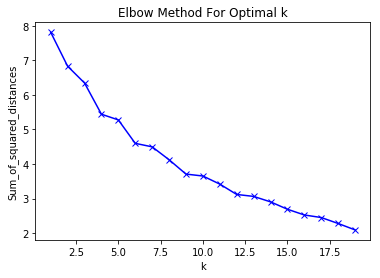

In [39]:
import matplotlib.pyplot as plt
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

## Cluster Neighborhoods using K = 13


In [40]:
# set number of clusters
kclusters = 13

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(TO_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([12,  0,  0,  1,  6,  0, 12,  0,  0, 12,  5,  0,  1,  1,  5,  0, 10,
        1,  0,  0,  0, 12,  1, 12,  0, 12,  0,  1,  0,  0,  1,  1, 12, 12,
       12, 12, 12,  1,  1, 12,  8,  1,  2,  1,  1,  1,  0,  0, 12, 12,  5,
        1, 11,  3,  1,  0,  0, 12,  1,  4,  4,  4,  9,  1,  1,  9,  9,  0,
        4, 12, 12,  1,  7,  1,  7,  0,  0, 12,  5, 12,  9,  1,  1, 12,  5,
        5,  1,  1], dtype=int32)

In [41]:
# add clustering labels
#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted['Cluster Labels']= kmeans.labels_

In [42]:
neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Cluster Labels
0,Abu Hail,Bakery,Park,Filipino Restaurant,Department Store,Seafood Restaurant,12
1,Al Baraha,Hotel,Fast Food Restaurant,Middle Eastern Restaurant,Chinese Restaurant,Park,0
2,Al Barsha First,Hotel,Coffee Shop,Clothing Store,Middle Eastern Restaurant,Café,0
3,Al Barsha South Second,Convenience Store,Coffee Shop,Fast Food Restaurant,Bakery,Department Store,1
4,Al Barsha South Third,Furniture / Home Store,Gym,Coffee Shop,Zoo Exhibit,Fish Market,6
5,Al Buteen,Hotel,Middle Eastern Restaurant,Coffee Shop,Restaurant,Café,0
6,Al Garhoud,Airport Terminal,Airport Service,Fast Food Restaurant,Hotel,Coffee Shop,12
7,Al Hudaiba,Hotel,Middle Eastern Restaurant,Café,Asian Restaurant,Coffee Shop,0
8,Al Jaddaf,Golf Course,Restaurant,Steakhouse,Hotel,Tea Room,0
9,Al Jafiliya,Hotel,Coffee Shop,Restaurant,Lounge,Asian Restaurant,12


## Merge the original DF with the one which contains the cluster values

In [43]:
TO_merged = DubaiDF
TO_merged.rename(columns={"Community" : "Neighborhood"}, inplace = True)
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
TO_merged = TO_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

TO_merged.dropna(inplace = True) # check the last columns!

## Display the clusters on a folium map

In [44]:
import folium
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(TO_merged['Lat'], TO_merged['Lon'], TO_merged['Neighborhood'], TO_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Further data processing to convert the string density variables into float

In [45]:
i = 0
for text in TO_merged['Density']:
    if(isinstance(text, str)):
        if('km²' in text):
            TO_merged.iloc[i,3] = float((text.replace('/km²','')).replace(',',''))
        elif('km2' in text):
            TO_merged.iloc[i,3] = float((text.replace('/km2','')).replace(',',''))  
    i=i+1

## List out the communities or neighbourhoods per cluster

### Cluster 1 - dominated by restaurants, some coffee shops and shopping

In [77]:
TO_merged.loc[TO_merged['Cluster Labels'] == 0].sort_values(by = 'Density',ascending = False)

,Neighborhood,Area,Population,Density,Lat,Lon,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Cluster Labels
8,Al Karama,1.509 km2,45674,30267,25.244403,55.304755,Indian Restaurant,Café,Restaurant,Fast Food Restaurant,Asian Restaurant,0.0
0,Abu Hail,1.27 km²,21414,16861.4,25.285942,55.329444,Park,Coffee Shop,Bakery,Restaurant,Dessert Shop,0.0
12,Al Mankhool,1 km2,16013,16013,25.250827,55.295620,Indian Restaurant,Hotel,Fast Food Restaurant,Chinese Restaurant,Coffee Shop,0.0
52,Hor Al Anz,4.18 km²,40342,9651,25.277042,55.337300,Indian Restaurant,Fast Food Restaurant,Market,Convenience Store,Bakery,0.0
56,Jumeira First,6.9 km2,26499,3840,25.046345,55.189545,Fast Food Restaurant,Pizza Place,Ice Cream Shop,Shoe Store,Market,0.0
74,Umm Hurair First,2.3 km2,4428,1926,25.254192,55.310743,Indian Restaurant,Coffee Shop,Café,Hotel,Middle Eastern Restaurant,0.0
86,Al Barsha South Second,5,7100,1411,25.069928,55.226624,Convenience Store,Coffee Shop,Bakery,Fast Food Restaurant,Department Store,0.0
27,Al Quoz Second,27.1 km²,16719,617,25.124703,55.251207,Indian Restaurant,Hotel,Golf Course,Light Rail Station,Clothing Store,0.0
65,Nad Shiba 4,8.4 km²,2563,6.16,25.154553,55.245027,Indian Restaurant,Fast Food Restaurant,Shopping Mall,Department Store,Food Court,0.0
66,Nad Shiba 2,8.4 km²,2563,6.16,25.154553,55.245027,Indian Restaurant,Fast Food Restaurant,Shopping Mall,Department Store,Food Court,0.0


### Cluster 2 - dominated by Cafe, some restaurants and misc venues such as jewelry stores and airport terminals

In [78]:
TO_merged.loc[TO_merged['Cluster Labels'] == 1].sort_values(by = 'Density',ascending = False)

,Neighborhood,Area,Population,Density,Lat,Lon,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Cluster Labels
4,Hamriya,0.72 km²,15104,20890,25.287657,55.323997,Coffee Shop,Park,Market,Seafood Restaurant,Fishing Store,1.0
53,Hor Al Anz East,4.18 km²,40342,9651,25.282082,55.347623,Café,Middle Eastern Restaurant,Fast Food Restaurant,Gym,Shopping Mall,1.0
48,Al Wahda,1.41 km²,9856,6990,24.469070,54.373631,Café,Coffee Shop,Hotel,Italian Restaurant,Dessert Shop,1.0
63,Muhaisnah First,13 km²,90870,6990,25.244086,55.412118,Movie Theater,Park,Hostel,Bowling Alley,Baby Store,1.0
47,Al Wasl,4.76km²,22153,4654,25.198898,55.257049,Café,Middle Eastern Restaurant,Ice Cream Shop,Burger Joint,Coffee Shop,1.0
73,Umm Al Sheif,1.87 km²,6263,3350,25.132752,55.205857,Coffee Shop,Café,Jewelry Store,Restaurant,Grocery Store,1.0
39,Al Twar First,6.8 km²,18457,2714,25.270966,55.362787,Airport Terminal,Coffee Shop,Airport Lounge,Indian Restaurant,Fast Food Restaurant,1.0
40,Al Twar Second,6.8km²,18457,2714,25.261550,55.381747,Coffee Shop,Café,Indian Restaurant,Mobile Phone Shop,Boutique,1.0
41,Al Twar Third,6.8 km²,18457,2714,25.251084,55.396266,Fast Food Restaurant,Tunnel,Basketball Court,Indian Restaurant,Cafeteria,1.0
77,Umm Suqeim First,7.2 km²,16459,2286,25.162427,55.209815,Coffee Shop,Café,Burger Joint,Bakery,Middle Eastern Restaurant,1.0


### Cluster 3

In [79]:
TO_merged.loc[TO_merged['Cluster Labels'] == 2].sort_values(by = 'Density',ascending = False)

,Neighborhood,Area,Population,Density,Lat,Lon,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Cluster Labels
44,Al Warqa'a Fourth,21.6 km²,5,0.23,25.18712,55.437364,Grocery Store,Zoo Exhibit,Fast Food Restaurant,Entertainment Service,Ethiopian Restaurant,2.0


### Cluster 4 - all communities here adhere to one structure more or less

In [80]:
TO_merged.loc[TO_merged['Cluster Labels'] == 3].sort_values(by = 'Density',ascending = False)

,Neighborhood,Area,Population,Density,Lat,Lon,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Cluster Labels
60,Muhaisanah Fourth,13 km²,90870,6990,25.280555,55.410502,Business Service,Gym,Fast Food Restaurant,Hotel,Pet Service,3.0
61,Muhaisanah Second,13 km²,90870,6990,25.280555,55.410502,Business Service,Gym,Fast Food Restaurant,Hotel,Pet Service,3.0
62,Muhaisanah Third,13 km²,90870,6990,25.280555,55.410502,Business Service,Gym,Fast Food Restaurant,Hotel,Pet Service,3.0
21,Nasr,1.5 km²,2469,1646,25.281865,55.411010,Business Service,Gym,Fast Food Restaurant,Restaurant,Cheese Shop,3.0


### Cluster 5

In [81]:
TO_merged.loc[TO_merged['Cluster Labels'] == 4].sort_values(by = 'Density',ascending = False)

,Neighborhood,Area,Population,Density,Lat,Lon,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Cluster Labels
55,Jebel Ali Industrial,47.1 km²,31634,672,24.935281,55.075636,Coffee Shop,Zoo Exhibit,Filipino Restaurant,Entertainment Service,Ethiopian Restaurant,4.0


### Cluster 6 - dominated by hotels, restaurants and cafes; main distinctive element is the prevalence of hotels

In [82]:
TO_merged.loc[TO_merged['Cluster Labels'] == 5].sort_values(by = 'Density',ascending = False)

,Neighborhood,Area,Population,Density,Lat,Lon,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Cluster Labels
49,Ayal Nasir,0.17 km²,13077,76923,25.275307,55.303120,Hotel,Middle Eastern Restaurant,Fast Food Restaurant,Shopping Mall,Café,5.0
68,Naif,0.561 km²,28571,50928,25.272775,55.311351,Hotel,Middle Eastern Restaurant,Coffee Shop,Café,Fast Food Restaurant,5.0
17,Al Murar,0.41 km²,19831,48368,25.276677,55.309763,Hotel,Middle Eastern Restaurant,Asian Restaurant,Fast Food Restaurant,Café,5.0
16,Al Muraqqabat,0.78 km²,32395,41532,25.266308,55.324222,Hotel,Middle Eastern Restaurant,Coffee Shop,Restaurant,Café,5.0
29,Al Ras,0.20 km²,6812,34060,25.268885,55.296075,Hotel,Indian Restaurant,Middle Eastern Restaurant,Shopping Mall,Café,5.0
2,Al Buteen,0.07 km²,2364,33771,25.263057,55.320584,Hotel,Middle Eastern Restaurant,Coffee Shop,Restaurant,Café,5.0
32,Al Sabkha,0.13 km²,2627,20207,25.267181,55.303487,Hotel,Middle Eastern Restaurant,Indian Restaurant,Café,Asian Restaurant,5.0
18,Al Muteena,1.12 km²,18094,16155,25.273892,55.322630,Hotel,Indian Restaurant,Coffee Shop,Fast Food Restaurant,Asian Restaurant,5.0
37,Al Satwa,2.87 km²,30147,10504,25.221161,55.273836,Coffee Shop,Café,Middle Eastern Restaurant,Hotel,Restaurant,5.0
88,Marsa Dubai,5,45500,9300,25.087754,55.146172,Hotel,Coffee Shop,Restaurant,Café,Beach,5.0


### Cluster 7

In [83]:
TO_merged.loc[TO_merged['Cluster Labels'] == 6].sort_values(by = 'Density',ascending = False)

,Neighborhood,Area,Population,Density,Lat,Lon,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Cluster Labels
42,Al Warqa'a Fifth,21.6 km²,5,0.23,25.180477,55.452966,Zoo Exhibit,Ice Cream Shop,Trail,Farmers Market,English Restaurant,6.0


### Cluster 8

In [84]:
TO_merged.loc[TO_merged['Cluster Labels'] == 7].sort_values(by = 'Density',ascending = False)

,Neighborhood,Area,Population,Density,Lat,Lon,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Cluster Labels
54,Jebel Ali 2,47.1 km²,31634,672,25.028782,55.123823,Bar,Multiplex,Fast Food Restaurant,Italian Restaurant,Sports Club,7.0


### Cluster 9

In [85]:
TO_merged.loc[TO_merged['Cluster Labels'] == 8].sort_values(by = 'Density',ascending = False)

,Neighborhood,Area,Population,Density,Lat,Lon,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Cluster Labels
14,Al Mizhar First,11.2 km²,4326,386.25,25.245034,55.441748,Burger Joint,Bakery,Ethiopian Restaurant,Event Space,Fabric Shop,8.0


### Cluster 10

In [86]:
TO_merged.loc[TO_merged['Cluster Labels'] == 9].sort_values(by = 'Density',ascending = False)

,Neighborhood,Area,Population,Density,Lat,Lon,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Cluster Labels
24,Quoz Industrial 4,27.1 km²,16719,617,25.116968,55.231661,Soccer Field,Sporting Goods Shop,Martial Arts Dojo,Auto Workshop,Auto Garage,9.0
25,Quoz Industrial 2,27.1 km²,16719,617,25.116968,55.231661,Soccer Field,Sporting Goods Shop,Martial Arts Dojo,Auto Workshop,Auto Garage,9.0


### Cluster 11

In [87]:
TO_merged.loc[TO_merged['Cluster Labels'] == 10].sort_values(by = 'Density',ascending = False)

,Neighborhood,Area,Population,Density,Lat,Lon,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Cluster Labels
87,Al Barsha South Third,4,4600,1141,25.057962,55.227981,Convenience Store,Gym,Furniture / Home Store,Coffee Shop,Fast Food Restaurant,10.0


### Cluster 12

In [88]:
TO_merged.loc[TO_merged['Cluster Labels'] == 11].sort_values(by = 'Density',ascending = False)

,Neighborhood,Area,Population,Density,Lat,Lon,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Cluster Labels
80,Warsan First,17.1 km²,1421,83,25.160381,55.425285,Indian Restaurant,Hookah Bar,Chinese Restaurant,Supermarket,Furniture / Home Store,11.0
81,Warsan Second,17.1 km²,1421,83,25.160381,55.425285,Indian Restaurant,Hookah Bar,Chinese Restaurant,Supermarket,Furniture / Home Store,11.0


### Cluster 13 - mostly cafeterias and casual food restaurants

In [89]:
TO_merged.loc[TO_merged['Cluster Labels'] == 12].sort_values(by = 'Density',ascending = False)

,Neighborhood,Area,Population,Density,Lat,Lon,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Cluster Labels
30,Al Rashidiya,4.41 km²,22326,5062,25.224953,55.390507,Cafeteria,Coffee Shop,Middle Eastern Restaurant,Bakery,Light Rail Station,12.0
10,Al Mamzar,3.35 km²,2260,674.6,25.303247,55.343453,Beach,Cafeteria,Café,Grocery Store,Juice Bar,12.0
22,Al Quoz First,27.1 km²,16719,617,25.169145,55.252975,Cafeteria,Ice Cream Shop,Coffee Shop,BBQ Joint,Entertainment Service,12.0
28,Al Quoz Third,27.1 km²,16719,617,25.169070,55.253398,Cafeteria,Ice Cream Shop,Historic Site,Bowling Alley,Nightclub,12.0
64,Nad Hamar,8.4 km²,2563,6.16,25.201893,55.376374,Cafeteria,Sandwich Place,Clothing Store,Fast Food Restaurant,Basketball Court,12.0
43,Al Warqa'a First,21.6 km²,5,0.23,25.190247,55.402941,Cafeteria,Bookstore,Tea Room,Burger Joint,Market,12.0
45,Al Warqa'a Second,21.6 km²,5,0.23,25.200975,55.408048,Burger Joint,Middle Eastern Restaurant,Fast Food Restaurant,Cafeteria,Café,12.0
46,Al Warqa'a Third,21.6 km²,5,0.23,25.191657,55.419019,Shopping Mall,Ice Cream Shop,Tea Room,Bookstore,BBQ Joint,12.0


In [46]:
TO_merged.sort_values("Density", ascending = False)

,Neighborhood,Area,Population,Density,Lat,Lon,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Cluster Labels
49,Ayal Nasir,0.17 km²,13077,76923,25.275307,55.303120,Hotel,Middle Eastern Restaurant,Café,Fast Food Restaurant,Shopping Mall,0.0
68,Naif,0.561 km²,28571,50928,25.272775,55.311351,Hotel,Middle Eastern Restaurant,Fast Food Restaurant,Coffee Shop,Café,0.0
17,Al Murar,0.41 km²,19831,48368,25.276677,55.309763,Hotel,Middle Eastern Restaurant,Asian Restaurant,Fast Food Restaurant,Café,0.0
16,Al Muraqqabat,0.78 km²,32395,41532,25.266308,55.324222,Hotel,Middle Eastern Restaurant,Coffee Shop,Restaurant,Café,0.0
29,Al Ras,0.20 km²,6812,34060,25.268885,55.296075,Indian Restaurant,Hotel,Middle Eastern Restaurant,Café,Electronics Store,0.0
2,Al Buteen,0.07 km²,2364,33771,25.263057,55.320584,Hotel,Middle Eastern Restaurant,Coffee Shop,Restaurant,Café,0.0
8,Al Karama,1.509 km2,45674,30267,25.244403,55.304755,Indian Restaurant,Café,Restaurant,Asian Restaurant,Seafood Restaurant,5.0
4,Hamriya,0.72 km²,15104,20890,25.287657,55.323997,Park,Filipino Restaurant,Seafood Restaurant,Café,Hotel,12.0
32,Al Sabkha,0.13 km²,2627,20207,25.267181,55.303487,Hotel,Middle Eastern Restaurant,Indian Restaurant,Café,Restaurant,0.0
0,Abu Hail,1.27 km²,21414,16861.4,25.285942,55.329444,Bakery,Park,Filipino Restaurant,Department Store,Seafood Restaurant,12.0
